In [1]:
from rl.markov_process import (
    MarkovProcess,
    FiniteMarkovRewardProcess,
    NonTerminal,
    State,
    Terminal,
)

from rl.distribution import Categorical, Constant, FiniteDistribution


import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint

import pandas as pd

from dataclasses import dataclass

from typing import Dict, Mapping, Tuple


#### 1. Modeling Snakes and Ladders as a Markov Process

* A traditional Snakes and Ladders board consists of 100 numbered tiles $\mathcal{T} = \{0, 1, 2, \dots, 99\}$.  We define the transition map $\phi$ by $\phi(i) =j$ if there exists a snake or ladder from tile $i$ to tile $j$; otherwise, $\phi(i) = i$.  Moreover, we stipulate that $\phi(0) = 0$, and $\phi(99) = 99$.

* The state space of a Snakes and Ladders game could be understood as the image set $\phi(\mathcal{T}) = \mathcal{S} \subseteq \{0, 1, 2, \dots 99 \}$ containing $0$ and $99$ as initial and terminal states, respectively.

#### Transition Structure

* Assume that we are playing Snakes and Ladders with a fair die of $N$ sides.  From a given state $s_t$, our next state is the random variable $\phi(s_t + i)$, where $i$ denotes the rolled number.

In [2]:
@dataclass
class SnakesLadders_Board:
    """Class storing the positions of snakes and ladders on board."""

    tile_array: np.ndarray

    @property
    def terminal_tile_idx(self):
        return len(self.tile_array) - 1

    def __len__(self):
        return len(self.tile_array)

    @classmethod
    def generate_snakes_ladders(
        cls,
        boardsize: int,
        num_snakes: int,
        num_ladders: int,
    ) -> "SnakesLadders_Board":
        """Randomly generate positions of a given number of snakes and ladders."""
        unoccupied_spots = np.ones(shape=(boardsize), dtype=bool)
        tile_array = np.arange(boardsize)
        snake_counter, ladder_counter = 0, 0

        while snake_counter < num_snakes or ladder_counter < num_ladders:
            i = randint(1, boardsize - 1)
            while unoccupied_spots[i]:

                if snake_counter < num_snakes and i > 2:
                    snake_tail = randint(1, i)
                    if unoccupied_spots[snake_tail]:
                        tile_array[i] = snake_tail
                        unoccupied_spots[i] = False
                        unoccupied_spots[snake_tail] = False
                        snake_counter += 1

                elif ladder_counter < num_ladders and i < 99:
                    ladder_head = randint(i, boardsize)
                    if unoccupied_spots[ladder_head]:
                        tile_array[i] = ladder_head
                        unoccupied_spots[i] = False
                        unoccupied_spots[ladder_head] = False
                        ladder_counter += 1

        return SnakesLadders_Board(tile_array)

In [3]:
board = SnakesLadders_Board.generate_snakes_ladders(boardsize=100, num_ladders=10, num_snakes=10)
board

SnakesLadders_Board(tile_array=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  3, 11, 12, 13, 14,  6, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 16, 30, 48, 32, 33,
       34, 35, 79, 37, 38, 60, 63, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 42, 53, 18, 24, 56, 57, 65, 59, 60, 61, 62, 63, 47, 65, 66, 67,
       68, 69, 70, 98, 72, 73, 74, 89, 90, 77, 78, 79, 80, 81, 74, 86, 95,
       85, 86, 87, 88, 89, 90, 21, 62, 93, 94, 95, 96, 97, 98, 99]))

In [4]:
@dataclass
class SnakesLadders_State(int):
    tile_number: int

    def __hash__(self):
        return super().__hash__()


class SnakesLadders_Mapping:
    """Transition map storing probabilities from each state."""
    def __init__(self):
        self.state_map: Dict[NonTerminal[State], float] = {}

    def add_state(self, state: SnakesLadders_State, prob: float) -> None:
        if state in self.state_map.keys():
            self.state_map[state] += prob
        else:
            self.state_map[state] = prob


@dataclass
class SnakesLadders_Position(MarkovProcess[SnakesLadders_State]):
    die_sides: int
    board: SnakesLadders_Board

    def transition(
        self, init_state: NonTerminal[SnakesLadders_State], debug: bool = False
    ) -> Categorical[State[SnakesLadders_State]]:
        
        state_mapping = SnakesLadders_Mapping()
        
        for roll in range(1, self.die_sides + 1):
            if init_state.state.tile_number + roll < self.board.terminal_tile_idx:
                state_mapping.add_state(
                    NonTerminal(
                        SnakesLadders_State(
                            self.board.tile_array[init_state.state.tile_number + roll]
                        )
                    ),
                    1 / self.die_sides,
                )
            else:
                state_mapping.add_state(
                    Terminal(SnakesLadders_State(self.board.terminal_tile_idx)),
                    1 / self.die_sides,
                )

        return Categorical(state_mapping.state_map)


In [5]:
init_state = NonTerminal(SnakesLadders_State(0))
init_dist = Constant(init_state)

#transition probabilities from the initial state
slp =  SnakesLadders_Position(die_sides=6, board=board)
slp.transition(init_state)

{NonTerminal(state=SnakesLadders_State(tile_number=1)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=2)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=3)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=4)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=5)): 0.16666666666666669, NonTerminal(state=SnakesLadders_State(tile_number=6)): 0.16666666666666669}

#### Sampling Traces

Text(0.5, 0, 'roll number')

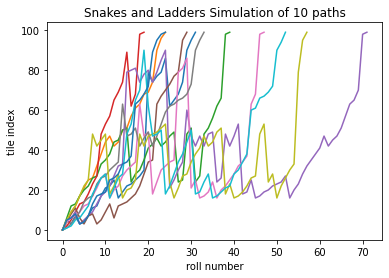

In [6]:
total_num_paths = 10

path_num = 0
for trace in slp.traces(init_dist):
    plt.plot([sim_state.state.tile_number for sim_state in trace])
    path_num += 1
    if path_num > total_num_paths:
        break
plt.title(f"Snakes and Ladders Simulation of {total_num_paths} paths")
plt.ylabel("tile index")
plt.xlabel("roll number")

#### Distribution of Elapsed Timesteps to Finish the Game

34.49635


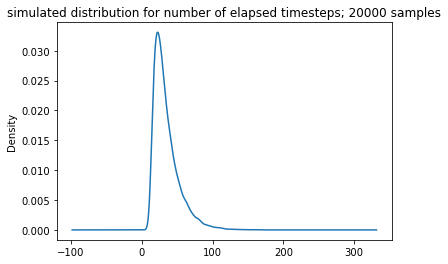

In [7]:
x = 0
rolls = []
n_sims = 20_000
for _ in np.arange(n_sims):
    n_rolls = -1
    for state in slp.simulate(init_dist):
        n_rolls += 1
    x += 1
    rolls.append(n_rolls)

pd.Series(rolls).plot(kind='density', title = f"simulated distribution for number of elapsed timesteps; {n_sims} samples")
print(np.mean(rolls))

#### 4.  Modeling Snakes and Ladders as a Finite Markov Reward Process

In [8]:
class SnakesLaddersMRPFinite(FiniteMarkovRewardProcess[SnakesLadders_State]):

    def __init__(self, board: SnakesLadders_Board, die_sides: int):
        self.board = board
        self.die_sides = die_sides
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> Mapping[SnakesLadders_State, FiniteDistribution[Tuple[SnakesLadders_State, Tuple]]]:
        d: Dict[SnakesLadders_State, Categorical[Tuple[SnakesLadders_State, float]]] = {}
        reward = 1.0
        for tile_idx in np.arange(len(self.board) - 1):
            if tile_idx == self.board.tile_array[tile_idx]:
                state = SnakesLadders_State(tile_idx)
                sr_probs_map: Dict[Tuple[SnakesLadders_State, float], float] = {}
                for roll in np.arange(1, self.die_sides + 1):
                    next_state: SnakesLadders_State
                    if state.tile_number + roll < self.board.terminal_tile_idx:
                        next_state = SnakesLadders_State(self.board.tile_array[state.tile_number + roll])
                    else:
                        next_state = SnakesLadders_State(self.board.terminal_tile_idx)
                    
                    if (next_state, reward) in sr_probs_map.keys():
                        sr_probs_map[(next_state, reward)] += 1/self.die_sides
                    else:
                        sr_probs_map[(next_state, reward)] = 1/self.die_sides
                d[state] = Categorical(sr_probs_map)
        return d

In [9]:
mrp = SnakesLaddersMRPFinite(board = board, die_sides = 6)
V = mrp.get_value_function_vec(gamma = 1.0)
print(V)

[34.48323433 34.16298412 33.82645534 33.55580062 33.55580062 33.11895499
 32.67941031 32.24148284 31.80728265 31.93187231 30.49788119 30.04214223
 29.61391806 29.20208148 27.83932371 27.61041134 27.3077085  27.04457301
 26.73106203 26.37231474 25.96987266 26.23693709 25.49149147 25.46576006
 24.84999614 24.21983103 23.55522014 21.01881775 21.15541259 20.43884038
 19.56755479 20.63182075 23.44645461 23.83989863 27.01741654 26.77369584
 26.56846829 26.20056275 25.71601301 25.86711056 24.9786488  25.31137161
 25.33710302 23.99312953 22.80871455 19.64787824 15.92928857 15.70222467
 17.02742812 16.1394071  15.42475972 14.85278371 14.33984128 10.4291281
 10.81128098 11.13687545 11.42092766 11.26218666 10.94349785 13.10419827
 13.09044229 13.12524089 14.45314174 12.61525906 13.00790637 13.3340325
 13.34562235 15.36379023 15.2907893  13.4151614  11.76337027 10.30974065
  9.031365    2.16139403  1.85262346  1.58796296  1.36111111  1.16666667
  1.        ]


In [10]:
init_state = NonTerminal(SnakesLadders_State(0))
init_dist = Constant(init_state)

#### Verification of the Value Function with Monte Carlo Simulation

Text(0.5, 0, 'roll number')

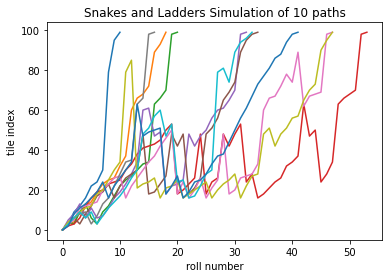

In [11]:
total_num_paths = 10

path_num = 0
for trace in mrp.traces(init_dist):
    plt.plot([sim_state.state.tile_number for sim_state in trace])
    path_num += 1
    if path_num > total_num_paths:
        break
plt.title(f"Snakes and Ladders Simulation of {total_num_paths} paths")
plt.ylabel("tile index")
plt.xlabel("roll number")

Value function at initial state: 34.48323433247902
simulation mean: 34.48008


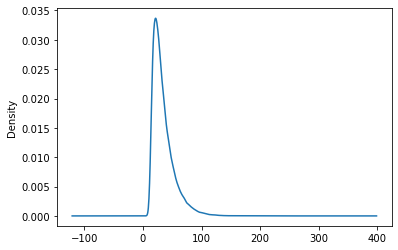

In [12]:
x = 0
rolls = []
while x < 100_000:
    n_rolls = -1
    for state in mrp.simulate(init_dist):
        n_rolls += 1
    x += 1
    rolls.append(n_rolls)

pd.Series(rolls).plot(kind='density')
print(f"Value function at initial state: {V[0]}")
print(f"simulation mean: {np.mean(rolls)}")